# Project Initialization

## Keywords


*   Time Series Forecasting
*   Seasonal Decomposition
*   Stationarity Testing
*   ACF + PACF
*   ARIMA
*   SARIMAX


## Background Research 


The goal for this project is to perform Time Series Forecasting on Air Pollution Dataset. We are given a training dataset to build your time series model, and to make prediction using the test dataset.

## Objective

> To forecast the Air Quality of Carbon Monoxide CO, Hydrocarbon(s) HC, Nitrous Dioxide NO2 and Ozone O3 for the next 63 Days(test size) using Univariate and Multivariate Statistical Model.

### Define "Value" feature in Raw Datast 


## Dataset Background

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

The original dataset collected readings on a hourly basis. However, the data from dataset given is on a daily basis. After manually calculating certain rows,we can confirm that the daily readings are derived from averaging the 24hours of that particular day.

For now, we will keep this fact in mind and explore more on the implicaitons of missing values in the EDA process



## Load Dependencies

In [2]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
from IPython.display import display, HTML, Markdown
# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Load Train Dataset
Date formatting of the data does not follow the standard Pandas convention.
Therefore specift date formatting to convert date feature to Datetime

Time range for Train Dataset spans over 13 months from 03-2016 to 02-2017

In [3]:
df_raw = pd.read_csv('../Data/train.csv')
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
display(df_raw)

,Date,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
0,2016-03-15,12.020833,54.883334,CO,1053.200000,NaN,NaN
1,2016-03-16,9.833333,64.069791,CO,995.250000,NaN,NaN
2,2016-03-17,11.292708,51.107292,CO,1025.250000,NaN,NaN
3,2016-03-18,12.866319,51.530903,CO,1064.444444,NaN,NaN
4,2016-03-19,16.016667,48.843750,CO,1088.741667,NaN,NaN
...,...,...,...,...,...,...,...
1307,2017-02-01,5.267708,39.614930,O3,553.180556,NaN,NaN
1308,2017-02-02,-55.515972,-24.010417,O3,343.500000,NaN,NaN
1309,2017-02-03,-14.272917,28.563542,O3,334.458333,NaN,NaN
1310,2017-02-04,4.848611,37.832986,O3,379.513889,NaN,NaN


In [8]:
print(f'Start Date:{df_raw["Date"].min()}\nEnd Date: {df_raw["Date"].max()}')

Start Date:2016-03-15 00:00:00
End Date: 2017-02-05 00:00:00


## Datetime Index

Since we are given a panel data, a time series with more than one relative variable in the same period.

We will be creating a datetime index 

In [4]:
df_raw.set_index('Date', inplace=True)
display(df_raw)

,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
Date,,,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000,NaN,NaN
2016-03-16,9.833333,64.069791,CO,995.250000,NaN,NaN
2016-03-17,11.292708,51.107292,CO,1025.250000,NaN,NaN
2016-03-18,12.866319,51.530903,CO,1064.444444,NaN,NaN
2016-03-19,16.016667,48.843750,CO,1088.741667,NaN,NaN
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,O3,553.180556,NaN,NaN
2017-02-02,-55.515972,-24.010417,O3,343.500000,NaN,NaN
2017-02-03,-14.272917,28.563542,O3,334.458333,NaN,NaN


# Exploratory Data Analysis

In our EDA for time series anaylsis on Air pollution dataset. We want to acomplish the following: 


*   Visualize Time series
*   Check Stationary of Data
*   Decompose the time series into it's components
  *  Seasonal Component ($S_t$)
  *  Trend-Cycle component ($T_t$)
  *  Remainder components ($R_t$)
* Strength of Trend and Seasonality of Gas values


## Initial Time series Visualization



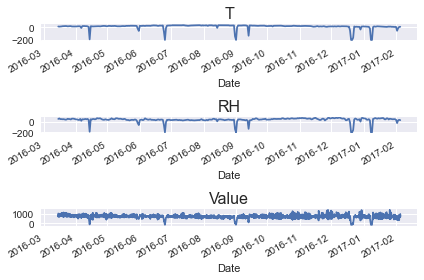

In [10]:
features = ["T",	"RH",	"Value"]

# Seaborn plot styling

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.autolayout'] = True


# Preliminary Line Plots
fig = plt.figure(tight_layout=True)
for i, column in enumerate(features):
    ax = fig.add_subplot(len(features), 1, i + 1)
    df_raw[column].plot(ax=ax)
    ax.set_title(column, fontsize=16)
plt.show()

Observations: 


*   There is a consistent reoccurence in extreme negative values across T , RH and Value series. I.e When any features T, RH or Values spikes towards a negative values at a particular point in time all feautues will spike down at the datetime index
*   Value Series looks too clustered, with high variance in quantity.


Actions

* Perform E-noise Drifting for negative Values 
* check on Value and it's relationship with other variables

## Pivoting Table
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row turning every gas into its individual column. 

In [5]:
df_raw_pivot = pd.pivot(df_raw, values="Value", columns="Gas")
df_raw_pivot[["T", "RH"]] = df_raw[["T", "RH"]].groupby(df_raw.index).mean()

df_raw_pivot

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,474.291667,347.480556,508.180556,343.500000,-55.515972,-24.010417
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


## What's the frequency of time series data

In [12]:
df_raw_pivot.index

DatetimeIndex(['2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18',
               '2016-03-19', '2016-03-20', '2016-03-21', '2016-03-22',
               '2016-03-23', '2016-03-24',
               ...
               '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03',
               '2017-02-04', '2017-02-05'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

From the looks of sameple index, it seems to be daily. We still will need to verify this


In [13]:
len(df_raw_pivot) - len(df_raw_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency

In [6]:
df_raw_pivot = df_raw_pivot.asfreq("D") # explicitly state a daily frequency

## Missing Values

After some digging, I found that the original source of the dataset is from  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality). 

What's interesting is that they denoted:

> "Missing values are tagged with -200 value" 

Let's take a deeper analysis to check the implications when -200 on the Values of Gases

In [15]:
display(df_raw_pivot[df_raw_pivot['T'] == -200])

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-06-25,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-09-01,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-20,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-21,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-08,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-09,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0


Observations:
When Temperature `T` or `RH` have Values of -200, all the other gases will have values of -160

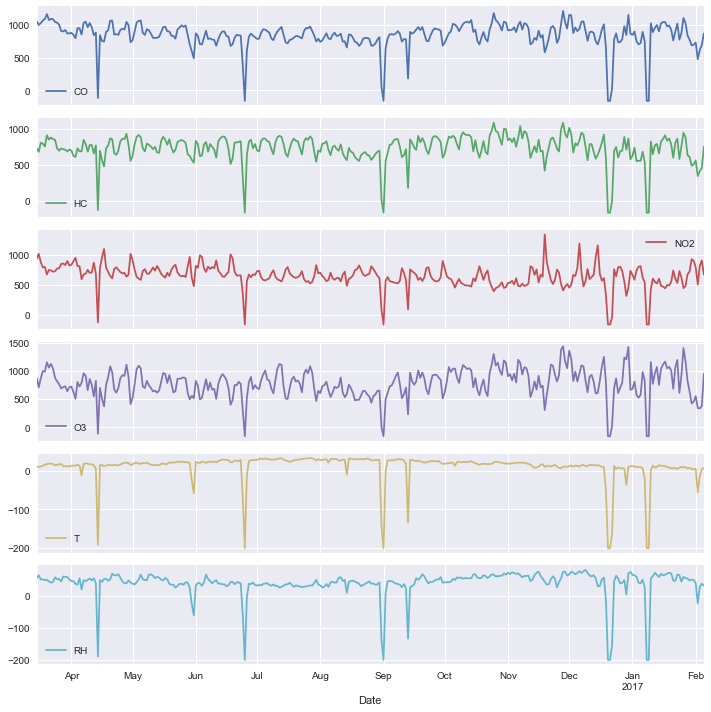

In [16]:
df_raw_pivot.plot(subplots=True, figsize=(10, 10))
plt.show()

**Observations**



*   There's interesting trend that when either one of the gasses are tagged with -160 value, the rest of the gasses will be -160 as well
*   The extreme values 

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

**Action**

*    impute the missing value using the front-fill(replace missing value with value before) method instead of dropping it.




In [11]:
Gases = ['CO','HC','NO2','O3']


display(df_raw_pivot[(df_raw_pivot[Gases]== -160).any(axis = 1)]) # Show Row with -160
df_pivot_impute = df_raw_pivot[['CO','HC','NO2','O3','T','RH']].replace({-160: np.NaN,-200: np.NaN}) # Replace Gases Values -160 and Temperature/RH values -200 with Null

df_pivot_impute = df_pivot_impute.sort_index().fillna(method='ffill') # Sort Index and Front-Fill
print("\nNumber of Missing Rows : \n{}".format(df_pivot_impute.isnull().sum()))



Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-06-25,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-09-01,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-20,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2016-12-21,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-08,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0
2017-01-09,-160.0,-160.0,-160.0,-160.0,-200.0,-200.0



Number of Missing Rows : 
Gas
CO     0
HC     0
NO2    0
O3     0
T      0
RH     0
dtype: int64


## E-Nose Drifting

Even after imputing the missing values -200 and -160 as NaN.

The minumum values for Temperature is still -191 degrees, which is ilogical for climate in Spain ( which the dataset was taken from )

Furthermore Relative Humidity percentage metric, thus even more ilogical for percentage to be negative



---
After digging around the orginal dataset FROM UCI repository, and comparing it with the given dataset, I found out that when the school merged the hourly readings from the original dataset, they merged days that certain contains both missing and actual readings per hour

As a result if just 1hour out of the 24 hours in a day had actual readings the averaged value will be slightly lower than -200 OR < -160 for gases

In [28]:
df_pivot_impute.min()

Gas
CO       579.758333
HC          414.475
NO2         317.875
O3       303.966667
T        -36.022917
RH         4.436111
Drift         False
dtype: object

## Imputing drifted missing values

We will use a threshold value of `T` < 0 to extract all partically affected missing value ( as explained above )

In [27]:
# Create Boolean Column to Indicate Drifting when Temperature is less than -49 OR RH < 0 (Abnormal)

df_pivot_impute['Drift'] = (df_pivot_impute['T'] < -49) | (df_pivot_impute['RH'] < 0)

# Extract drift rows
df_pivot_impute[df_pivot_impute['Drift'] == True]

Gas,CO,HC,NO2,O3,T,RH,Drift
Date,,,,,,,


### Visualizing Drifted values

In [26]:
g = sns.FacetGrid(
        pd.melt(
            df_pivot_impute, 
            id_vars='Drift', 
            value_vars=['T', 'RH', 'CO','HC','NO2','O3'], 
            ignore_index=False).reset_index(), 
        col="Gas", 
        hue = 'Drift',
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
# Add legend
g.add_legend()
g.fig.subplots_adjust(top=0.9) # adjust the Figure in g
g.fig.suptitle('ONE TITLE FOR ALL')

plt.show()

KeyError: 'Drift'

Observations: 
* Using only `T` and `RH` as the indicator to a drifting, we can see similar drifted values from all other `gas` values. Indicating, when either temperature or RH sensors is faluty, the sensors all the gases become faluty as well
* It seems like drifting values appear randomly following no repeated pattern

**Action**

Front fill all values for drifted data

In [23]:
df_pivot_impute.loc[df_pivot_impute['Drift']] = np.nan
df_pivot_impute = df_pivot_impute.fillna(method = 'ffill')
df_pivot_impute.drop(columns= 'Drift', inplace = True)
df_pivot_impute

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


In [21]:

temp_df = pd.melt(
            df_pivot_impute, 
            id_vars='Drift', 
            value_vars=['T', 'RH', 'CO','HC','NO2','O3'], 
            ignore_index=False)
temp_df

,Drift,Gas,value
Date,,,
2016-03-15,False,T,12.020833
2016-03-16,False,T,9.833333
2016-03-17,False,T,11.292708
2016-03-18,False,T,12.866319
2016-03-19,False,T,16.016667
...,...,...,...
2017-02-01,False,O3,553.180556
2017-02-02,True,O3,343.500000
2017-02-03,False,O3,334.458333


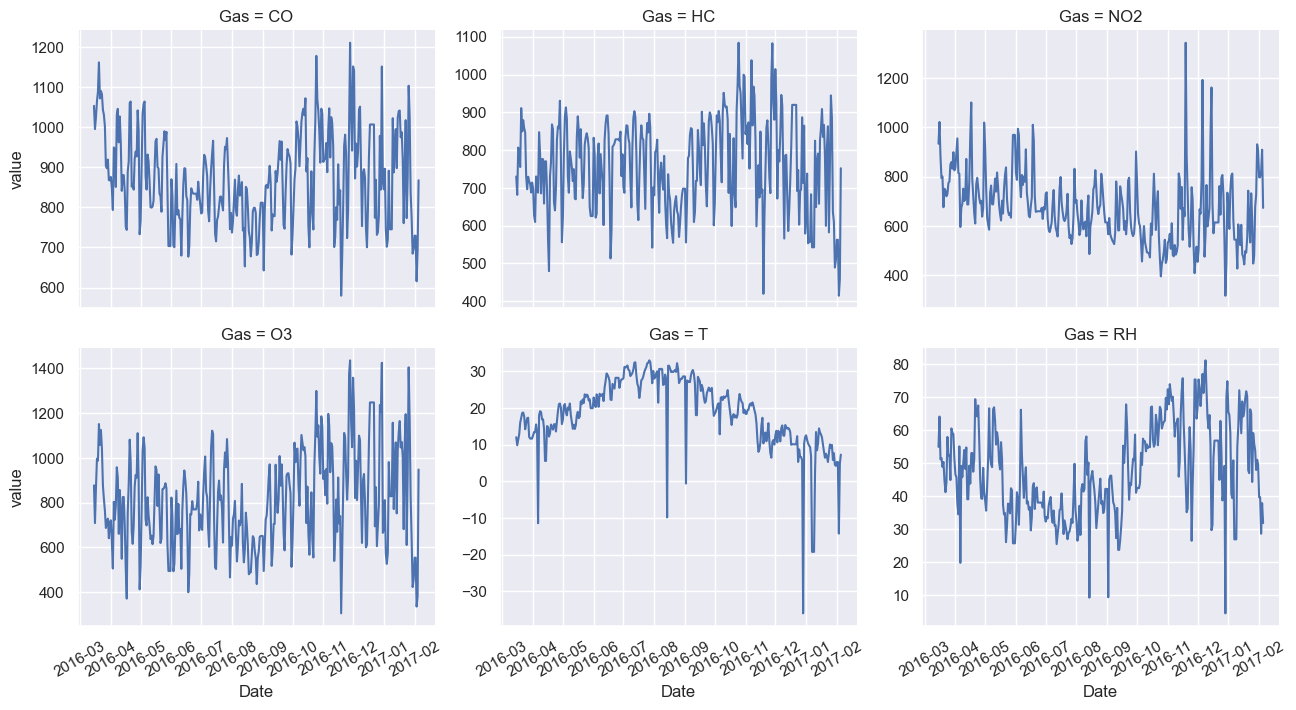

In [24]:
# Time series plot after imputation

g = sns.FacetGrid(
        pd.melt(
            df_pivot_impute, 
            ignore_index=False).reset_index(), 
        col="Gas",
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
plt.show()


# Stationary test

Knowing if our data is stationary is neccessary as having Stationary data one of the statistical assumptions that may be made by our models (ARIMA models)

Stationary data represents  **mean, variance and covariance does not vary with time.**

There are two statistical test we can perform to check for stationary data


*   Augmented Dickey-Fuller Test ( ADF )
*   Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

We will choose to apply/run both the tests and makes sure that the series is truly stationary



## ADF test for stationary

To verify stationarity, we will be utilising Augmented Dickey Test at Significant Value, $p=0.05$ with,
$$
H_0 : \text{Time-Series is Non-Stationary} \\
H_1 : \text{Time-Series is Stationary} 
$$

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [23]:
significance_level = 0.05
for feature in df_pivot_impute.columns:
    print(f'\n{feature}')
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(df_pivot_impute[feature])
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    display(test_statistic, pvalue, usedlag)



CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.


-8.313006601537845

3.744835659431997e-13

1


HC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.004
Used Lag: 14
Reject H0. There is evidence that the time series is stationary.


-3.6992050905087264

0.004124349155452832

14


NO2
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.001
Used Lag: 6
Reject H0. There is evidence that the time series is stationary.


-3.990876549376561

0.001459045032679178

6


O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.015
Used Lag: 12
Reject H0. There is evidence that the time series is stationary.


-3.294132470421681

0.015142799180085213

12


T
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.784
Used Lag: 6
Fail to reject H0. There is insufficient evidence that the time series is stationary.


-0.9120895363373888

0.7839650927246518

6


RH
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.001
Used Lag: 2
Reject H0. There is evidence that the time series is stationary.


-4.270012645958198

0.0005004328999795043

2

ADF Conclusions:

*   All Gases `CO`,`HC`, `NO2` and `O3` time series are stationary at $p=0.05$ 
*   Only `T` temperature does not appear to be stationary 



## KPSS test for stationary

In [24]:
def KPPS_test(df, significance_level = 0.05, columns = ['CO', 'HC', 'NO2', 'O3', 'T', 'RH'],diff=False):
  for feature in columns:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      if diff:
        print(f'\n{feature},difference=1')
      else:
        print(f'\n{feature}')
      print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
      if diff:
        test_statistic, pvalue, usedlag, *_ = kpss(df[feature].diff().dropna(), regression="c", nlags="auto")
      else:
        test_statistic, pvalue, usedlag, *_ = kpss(df[feature], regression="c", nlags="auto")
      print(f"P-value: {pvalue:.3f}")
      print(f"Used Lag: {usedlag}")
      if pvalue < significance_level:
          print("Reject H0. There is evidence that the time series is not stationary.")
      else:
          print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
      display(test_statistic, pvalue, usedlag)

In [25]:
KPPS_test(df_pivot_impute)


CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 8
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.30709743147091745

0.1

8


HC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 7
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.16100959835235773

0.1

7


NO2
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


1.420563948683637

0.01

8


O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


0.8536875424850573

0.01

8


T
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 11
Reject H0. There is evidence that the time series is not stationary.


1.078712824136766

0.01

11


RH
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


1.0137600878710762

0.01

10

KPSS Observations:

*   Only Gases `CO` and `HC` time series are **stationary** at $p=0.05$ 
*   Gases `NO2` and `O3` time series is **not stationary** at $p=0.05$ 
*   Both `T` and `RH` time series is **not stationary** at $p=0.05$ 

## Final Conclusiton for stationary test


1.   Time series for Gases `CO` and `HC`: Both tests conclude that the given series is stationary – These two series is stationary


> No differencing needed


2.  Time series for Gases `NO2` and `O3`: **ADF concludes stationary and KPSS concludes non-stationary** – These two series is difference stationary.

> Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

3. Time series for `T`: Both tests conclude that the given series is non-stationary – The series is non-stationary

4. Time series for `RH`: ADF concludes stationary and KPSS concludes non-stationary – The series is difference stationary.

[Reference: Statistical tests to check stationarity in Time Series](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=In%20python%2C%20the%20statsmodel%20package,the%20opposite%20to%20each%20other.)







In [26]:
KPPS_test(df_pivot_impute,columns=['NO2','O3'],diff=True)


NO2,difference=1
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 97
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.2442483943357942

0.1

97


O3,difference=1
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 38
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


0.06622079029482562

0.1

38

Conclusion:

After differencing `NO2` and `O3` by period=1 

KPPS test concluded time series stationary



# Seasonal Decomposition



---

Seasonal Decomposition
Column: CO
Seasonal 7


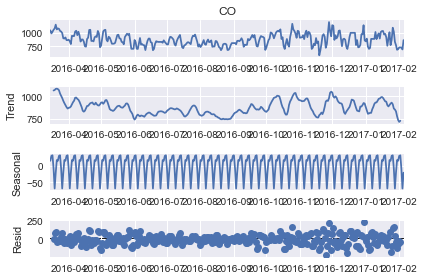

---

Seasonal Decomposition
Column: HC
Seasonal 7


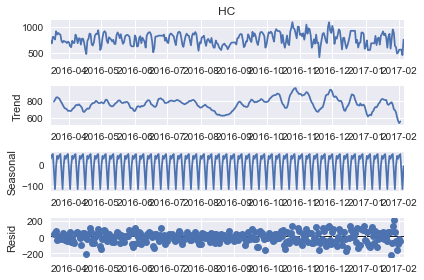

---

Seasonal Decomposition
Column: NO2
Seasonal 7


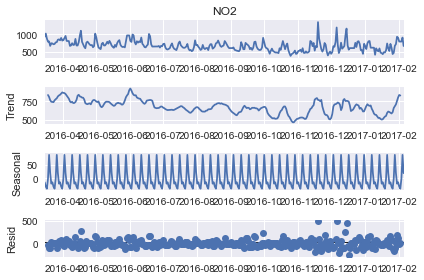

---

Seasonal Decomposition
Column: O3
Seasonal 7


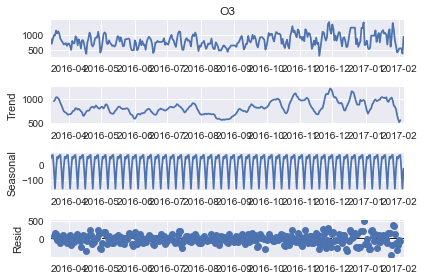

---

Seasonal Decomposition
Column: T
Seasonal 7


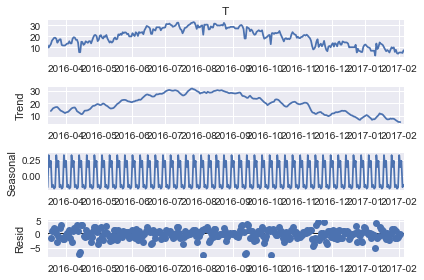

---

Seasonal Decomposition
Column: RH
Seasonal 7


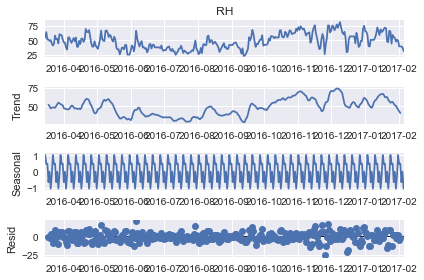

---

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal decomposition
display(Markdown('---'))
for i in df_pivot_impute.columns:
    print('Seasonal Decomposition\nColumn:', i)
    decomposition = seasonal_decompose(df_pivot_impute[i])
    print('Seasonal', len(decomposition.seasonal.drop_duplicates()))
    decomposition.plot()
    plt.show()
    display(Markdown('---'))

## Auto-Correlation & Partial Auto-Correlation Plot (ACF, PACF)

We will be using ACF and PACF plots to helps detect patterns and check for randomness in our time series data.

Using the ACF plot we want to answer the following questions:

* Is the observed time series white noise/random?
* Is an observation related to an adjacent observation, an observation twice-removed, and so on?
* Can the observed time series be modeled with an MA model? If yes, what is the order?

PACF to answer:

* Can the observed time series be modeled with an AR model? If yes, what is the order?

[References](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)

c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


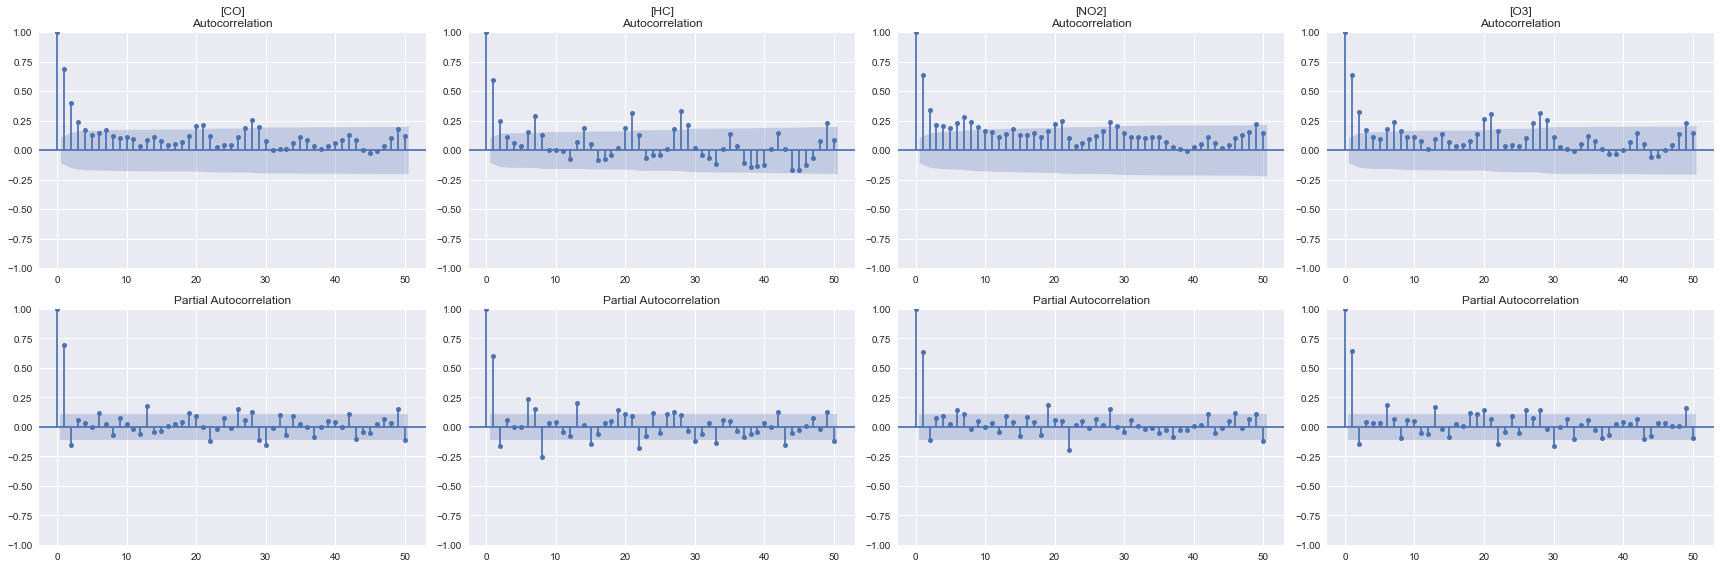

In [28]:
target_features = ['CO', 'HC', 'NO2', 'O3']

fig, axes = plt.subplots(2,4, figsize = (24,8))
for idx, variable in enumerate(target_features):
    plot_acf(df_pivot_impute[variable], lags = 50, ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df_pivot_impute[variable], lags = 50, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(variable))
plt.show()

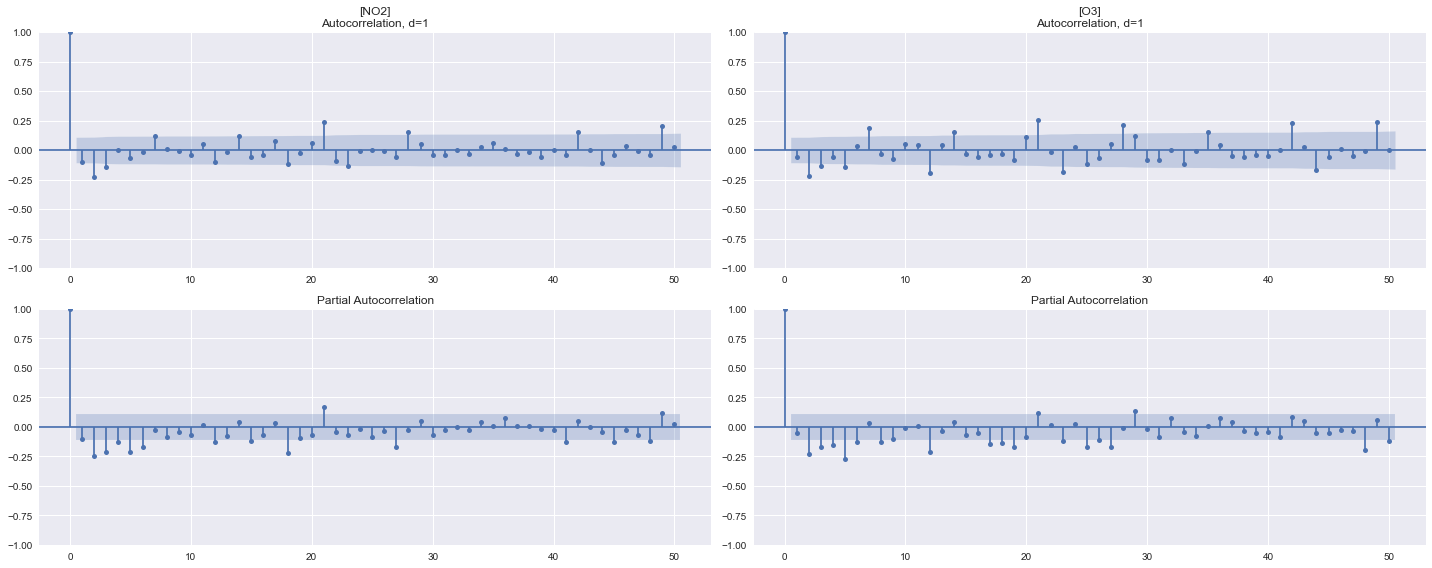

In [29]:
target_features = ['NO2', 'O3']

fig, axes = plt.subplots(2,2, figsize = (20,8))
for idx, variable in enumerate(target_features):
    plot_acf(df_pivot_impute[variable].diff().dropna(), lags = 50, ax = axes[0, idx]) # Looks for MA(q) with 
    plot_pacf(df_pivot_impute[variable].diff().dropna(), lags = 50, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation, d=1".format(variable))
plt.show()

Observations:

For all gases `CO`,`HC`, `NO2` and `O3`:


*   There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
*   List item


**Observation Summary OI FILL THIS SECTION UP ISTG this one fake**

| Gasses | AR(p significant lags) | MA(q significant lags) | Remarks | Potential Initial Model |
| ---    | ---   | ---   | :---                                   | :---    |
| CO     | 2     | 3   | Weak Seasonal Trend every 13 Iteration| MA(3)/ AR(2)/ ARMA(2,3)/SARIMA(2,0,3)(1,0,1,13) |
| NMHC   | 2     | 2     | Weak Seasonal Trend every 7 Iteration | MA(2)/ AR(2)/ ARMA(2,2)/ SARIMA(1,0,2)(2,0,1,7)
| NOx    | 2     | 2     | -                                     | MA(2)/ AR(2)/ ARMA(2,2) |
| O3     | 2     | 3     | Weak Seasonal Trend every 7 Iteration | MA(3)/ AR(2)/ ARMA(2,3)/SARIMA(1,0,2)(1,0,1,7)


# Modelling

## Backtesting for forecasting

There are two forms of Backtesting that we will attempt to perform



In [29]:
def modelEvaluation(model,endog,exog=None,tscv=TimeSeriesSplit(n_splits=3,test_size=63),test_size=63,target_features=[],curve=True,**kwargs):
  results = defaultdict(list)
  '''
  Function takes in 
  '''

  for idx, (train_idx,test_idx) in enumerate(tscv.split(endog)): # Expanding Window 
    if exog is not None:
      train_exog = exog.iloc[train_idx]
      test_exog = exog.iloc[test_idx]
    else:
      train_exog =None
      test_exog = None

    train_fold = endog.iloc[train_idx]
    test_fold = endog.iloc[test_idx]

    # display(train_exog)
    # display(train_fold)
    if exog is not None:
      res = model(train_fold, exog.iloc[train_idx], **kwargs).fit()
      print(res.summary())
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1],exog=train_exog)
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1],exog=test_exog)

    else:
      res = model(train_fold,**kwargs).fit()
      train_predict = res.predict(train_fold.index[0],train_fold.index[-1])
      # train_predict = res.forecast(len(train_idx))
      test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])

    # test_predict = res.predict(start=test_fold.index[0],end=test_fold.index[-1])

    rmse_train = mean_squared_error(train_fold, train_predict,squared=False) # Get train rmse for each split
    results['Train RMSE'].append(rmse_train)
    rmse_test = mean_squared_error(test_fold,test_predict,squared=False) # Get test rmse for each split
    results['Test RMSE'].append(rmse_test)
    results['Difference in RMSE'].append(rmse_train - rmse_test)
    results['AIC'].append(res.aic)

    print(f'this is idx:{idx}')
    if curve and idx==2 : # Only plot TS for last fold 
      axes[idx//2, idx%2].set_title("[{}]\nRMSE:{}".format(
        target_features[idx], rmse_test))
      axes[idx//2, idx%2].plot(endog, label = 'Actual', alpha=0.5)
      axes[idx//2, idx%2].plot(train_predict, label = 'Train', alpha=0.9)
      axes[idx//2, idx%2].plot(test_predict, label='Test', alpha=0.9)     
  # results['Train RMSE'] = np.array(['Train RMSE']).mean()
  # display(results)
  return results



## Analyse Results of model

In [12]:
def parse_results(results):
    cols = [pd.DataFrame(results[col]) for col in results.keys()]
    # display(cols)
    return pd.concat(cols, axis=1, keys=results.keys())

### Organise Results 

To keep track of model performance with varying parameters, we will store the model name (with specifications) , the Test RMSE and Gas of each model. This is to easily compare RMSE between models and across gases

In [13]:
Total_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Gas'])

def addHistory(model_name,cv_metrics,gas,past_history):
    cur_result = pd.Series({
        "Model Name" : model_name,
        "Mean Test RMSE" : np.mean(cv_metrics['Test RMSE']),
        'Difference in RMSE' : np.mean(cv_metrics['Difference in RMSE']),
        # "Final AICc" : np.mean(cv_metrics['Final AICc']),
        "Gas" : gas
    })
    history = past_history.append(cur_result, ignore_index=True)
    return history

## Arima Prediction

In [33]:
ARIMA_Results = defaultdict(list)

target_features = ['CO', 'HC', 'NO2', 'O3']
# target_features = ['CO']

orders = {
    "CO" : (1, 1, 0),
    "HC" : (1, 0, 1),
    "NO2" : (1, 0, 0),
    "O3" : (1, 0, 2)
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(target_features):
        order = orders[gas]
        eval_results = modelEvaluation(ARIMA, df_pivot_impute[gas],target_features=target_features, order = order)
        ARIMA_Results[gas] = eval_results


        Total_history = addHistory(f"ARIMA-{order}-{gas}", eval_results, gas, past_history=Total_history)
    # display(ARIMA_Results)

results = parse_results(ARIMA_Results).describe()
results.T

 25%|██▌       | 1/4 [00:00<00:00,  7.68it/s]

this is idx:0
this is idx:1
this is idx:2
this is idx:0


 50%|█████     | 2/4 [00:00<00:00,  3.77it/s]

this is idx:1
this is idx:2
this is idx:0


 75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]

this is idx:1
this is idx:2
this is idx:0
this is idx:1


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

this is idx:2


count         mean         std          min  \
CO  Train RMSE            3.0   106.100005    7.173673   100.297666   
    Test RMSE             3.0   131.502285   50.555228    76.682968   
    Difference in RMSE    3.0   -25.402280   57.698493   -75.991357   
    AIC                   3.0  2306.225018  752.212657  1573.196114   
HC  Train RMSE            3.0    78.320119    6.922256    74.161607   
    Test RMSE             3.0   130.115549   27.550987    99.697466   
    Difference in RMSE    3.0   -51.795429   27.021274   -79.232189   
    AIC                   3.0  2348.635144  761.330166  1601.254575   
NO2 Train RMSE            3.0    88.564581    7.200660    82.834473   
    Test RMSE             3.0   155.379981   38.029514   116.117292   
    Difference in RMSE    3.0   -66.815400   39.934865  -109.208436   
    AIC                   3.0  2392.279917  770.663215  1637.748996   
O3  Train RMSE            3.0   132.527386    9.394269   124.572618   
    Test RMSE             3.0   240.281143   68.303618   161.667714   
    Difference in RMSE    3.0  -107.753757   67.604630  -160.522581   
    AIC                   3.0  2561.096821  817.497906  1758.187397   

                                25%          50%          75%          max  
CO  Train RMSE           102.089575   103.881483   109.001174   114.120865  
    Test RMSE            109.108916   141.534864   158.911944   176.289023  
    Difference in RMSE   -56.822369   -37.653381    -0.107742    37.437898  
    AIC                 1921.209675  2269.223235  2672.739470  3076.255705  
HC  Train RMSE            74.324662    74.487717    80.399375    86.311034  
    Test RMSE            118.476425   137.255384   145.324590   153.393796  
    Difference in RMSE   -65.088270   -50.944351   -38.077050   -25.209749  
    AIC                 1961.359007  2321.463438  2722.325429  3123.187419  
NO2 Train RMSE            84.523228    86.211982    91.429635    96.647288  
    Test RMSE            137.048517   157.979743   175.011326   192.042910  
    Difference in RMSE   -85.270445   -61.332454   -45.618882   -29.905310  
    AIC                 1999.359334  2360.969673  2769.545378  3178.121084  
O3  Train RMSE           127.345203   130.117787   136.504770   142.891752  
    Test RMSE            217.874115   274.080515   279.587857   285.095199  
    Difference in RMSE  -145.855672  -131.188763   -81.369345   -31.549927  
    AIC                 2145.424606  2532.661816  2962.551533  3392.441250

In [34]:
Total_history

,Model Name,Mean Test RMSE,Difference in RMSE,Gas
0,"ARIMA-(1, 1, 0)-CO",131.502285,-25.402280,CO
1,"ARIMA-(1, 0, 1)-HC",130.115549,-51.795429,HC
2,"ARIMA-(1, 0, 0)-NO2",155.379981,-66.815400,NO2
3,"ARIMA-(1, 0, 2)-O3",240.281143,-107.753757,O3


## Baseline Model

With our sampling techniques set up, let us establish a baseline model to provide us another reference point to the performance of the model that we are building.

I will be using an [Average Forecast](https://otexts.com/fpp2/simple-methods.html#average-method) that **Predicts Current Observation based on the Mean** of the historical data. 

$$
\hat{y} = \frac{1}{T} \sum^T_{t=1} y_t
$$

The performance will be **Evaluated Using the Same Expanding Window** techniques as mentioned above.


In [35]:
TEST_SIZE = 63
target_feature = ['CO', 'HC', 'NO2', 'O3']

for gas in target_feature:
  cv_metrics= modelEvaluate(model=None,endog=df_pivot_impute[gas],baseline=True)
  Total_history = addHistory("Baseline_Average_Forecase",cv_metrics,gas,Total_history)

Total_history

NameError: name 'modelEvaluate' is not defined

## Visualizing ARIMA

We want to be able to visualize how our model actually predicts
To spot potential further improvements 

We will use the last 63 observation as the test set to visualise the forecast to mimic the Kaggle test set

In [ ]:
print('erridk')

## SARIMA 

Form the seasonal decomposistion, we can see that all gases follows a a strong seasonal trend, sooooooooooo

we will use yay 

We will first use the seasonal trend of 7 cus why not
WE will need to find the Seasonal orders

In [2]:
seasonal_orders = {
    "CO" : (2, 0, 0, 7),
    "HC" :  (3, 0, 0, 7),
    "NO2" :  (1, 0, 4, 7),
    "O3" :  (7, 0, 7, 7)
}
orders = {
    "CO" : (1, 0, 0),
    "HC" : (1, 0, 0),
    "NO2" : (1, 0, 0),
    "O3" : (1, 0, 2)
}
target_feature = ['CO', 'HC', 'NO2', 'O3']

SARIMA_Results = defaultdict(list)
file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(target_feature):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        final_model, cv_metrics = modelEvaluation(SARIMAX, df_pivot_impute[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order })
        SARIMA_Results[gas] = cv_metrics
        Total_history = addHistory(f"SARIMA-{order}-{seasonal_orders}-{gas}", cv_metrics, gas, past_history=Total_history)
results = parse_results(SARIMA_Results).describe()

NameError: name 'defaultdict' is not defined

In [ ]:
results.T

In [ ]:
Total_history

# VARMAX 

The VARMAX best used on a multivariate time series, which is suitable for our current Gas prediction time series, being given exog endogenous variables Temperature and RH. 

The VARMAX procedure estimates the model parameters and generates forecasts associated with vector autoregressive moving-average processes with exogenous regressors

[References: SAS/ETS®
13.2 User’s Guide
The VARMAX Procedure](https://support.sas.com/documentation/onlinedoc/ets/132/varmax.pdf)




## Test for causation

Before we can perform VARMAX , we need to test for causality, since the basis of these Multivariate Models, VAR and VARMAX, is that each time series in the system influences each other.


$$
H_0 : \text{There is no causality between time series} \\
H_1 : \text{There is some causality between time series} 
$$


Ideally, we would like to have some causation between time series, that way we could implement multivariate modelling.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)      


In [1]:
from assets.functions.grangers_causation_matrix import grangers_causation_matrix

g_test = grangers_causation_matrix(ts_pivot, variables=ts_pivot.columns, test='ssr_chi2test',
                                   verbose=False, maxlag=12)

ModuleNotFoundError: No module named 'assets'

In [ ]:
g_test.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

## VARMAX Data preprocessing


In [10]:
# create a dataset for VARMAX - clean data
# copy, remove any missing values, setting frequency within the datetime index
varmax_ts = df_pivot_impute.copy()
display(varmax_ts)

Gas,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-03,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930


In [11]:
# spliting into exogenous (X) and endog (y) variables
X_clean, y_clean = varmax_ts[['T', 'RH']], varmax_ts.drop(['T', 'RH'], axis=1)
print(X_clean.shape, y_clean.shape)

(328, 2) (328, 4)


In [ ]:
display(y_clean)

Gas,CO,HC,NO2,O3
Date,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333
2016-03-16,995.250000,681.441667,1021.750000,708.025000
2016-03-17,1025.250000,806.583333,881.375000,867.375000
2016-03-18,1064.444444,794.258333,794.527778,996.625000
2016-03-19,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556
2017-02-02,729.422222,562.650000,797.647222,553.180556
2017-02-03,729.422222,562.650000,797.647222,553.180556


## VARMAX Modelling


In [38]:
X_clean.iloc[327]
model = VARMAX(endog=y_clean, exog=X_clean, order=(1, 1)).fit(maxiter=1000, disp=False)

c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model.summary()

In [ ]:
VARMAX_Results = defaultdict(list)
target_features = ['CO', 'HC', 'NO2', 'O3']
# target_features = ['CO']


with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    eval_results = modelEvaluation(VARMAX, endog = y_clean,exog =X_clean, target_features=target_features, order = (1,0))
    VARMAX_Results[gas] = eval_results


    Total_history = addHistory(f"VARMA-All-(1,0)", eval_results, "All", past_history=Total_history)
    # display(VARMAX_Results)

results = parse_results(VARMAX_Results).describe()
results.T

Gas,T,RH
Date,,
2016-03-15,12.020833,54.883334
2016-03-16,9.833333,64.069791
2016-03-17,11.292708,51.107292
2016-03-18,12.866319,51.530903
2016-03-19,16.016667,48.843750
...,...,...
2016-07-27,32.997917,33.087500
2016-07-28,32.556944,31.853472
2016-07-29,30.113542,39.881250


Gas,CO,HC,NO2,O3
Date,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333
2016-03-16,995.250000,681.441667,1021.750000,708.025000
2016-03-17,1025.250000,806.583333,881.375000,867.375000
2016-03-18,1064.444444,794.258333,794.527778,996.625000
2016-03-19,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...
2016-07-27,972.916667,896.116667,527.475000,1083.991667
2016-07-28,907.669444,859.488889,550.791667,976.155556
2016-07-29,837.425000,686.375000,642.200000,694.608333


                               Statespace Model Results                              
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  139
Model:                               VARX(1)   Log Likelihood               -2883.408
                                 + intercept   AIC                           5842.816
Date:                       Sat, 06 Aug 2022   BIC                           5954.326
Time:                               08:39:37   HQIC                          5888.130
Sample:                           03-15-2016                                         
                                - 07-31-2016                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):     7.68, 0.44, 0.38, 0.89   Jarque-Bera (JB):       2.57, 1.83, 9.18, 0.50
Prob(Q):                0.01, 0.51, 0.54, 0.35   Prob(JB):               0.28, 0.40, 0.01, 0.78
Heteroskedasticity (H): 0.58, 0.95

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  ValueWarning)


Gas,T,RH
Date,,
2016-03-15,12.020833,54.883334
2016-03-16,9.833333,64.069791
2016-03-17,11.292708,51.107292
2016-03-18,12.866319,51.530903
2016-03-19,16.016667,48.843750
...,...,...
2016-09-28,25.499305,50.789583
2016-09-29,21.134375,58.608333
2016-09-30,17.850000,40.980556


Gas,CO,HC,NO2,O3
Date,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333
2016-03-16,995.250000,681.441667,1021.750000,708.025000
2016-03-17,1025.250000,806.583333,881.375000,867.375000
2016-03-18,1064.444444,794.258333,794.527778,996.625000
2016-03-19,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...
2016-09-28,927.388889,859.938889,570.436111,881.841667
2016-09-29,909.141667,817.100000,629.650000,842.016667
2016-09-30,682.358333,600.855556,902.097222,512.130556


                               Statespace Model Results                              
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  202
Model:                               VARX(1)   Log Likelihood               -4226.237
                                 + intercept   AIC                           8528.475
Date:                       Sat, 06 Aug 2022   BIC                           8654.189
Time:                               08:39:40   HQIC                          8579.339
Sample:                           03-15-2016                                         
                                - 10-02-2016                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):     11.37, 0.90, 0.48, 2.24   Jarque-Bera (JB):   9.20, 0.40, 300.05, 2.24
Prob(Q):                 0.00, 0.34, 0.49, 0.13   Prob(JB):             0.01, 0.82, 0.00, 0.33
Heteroskedasticity (H):  0.63, 1.00,

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  ValueWarning)


Gas,T,RH
Date,,
2016-03-15,12.020833,54.883334
2016-03-16,9.833333,64.069791
2016-03-17,11.292708,51.107292
2016-03-18,12.866319,51.530903
2016-03-19,16.016667,48.843750
...,...,...
2016-11-30,10.019097,63.455903
2016-12-01,12.494792,66.787500
2016-12-02,13.768750,75.313541


Gas,CO,HC,NO2,O3
Date,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333
2016-03-16,995.250000,681.441667,1021.750000,708.025000
2016-03-17,1025.250000,806.583333,881.375000,867.375000
2016-03-18,1064.444444,794.258333,794.527778,996.625000
2016-03-19,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...
2016-11-30,941.677778,880.294444,516.600000,1047.577778
2016-12-01,1151.566667,1014.225000,455.058333,1358.375000
2016-12-02,1140.800000,925.725000,503.475000,1215.200000


                               Statespace Model Results                              
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  265
Model:                               VARX(1)   Log Likelihood               -5668.584
                                 + intercept   AIC                          11413.168
Date:                       Sat, 06 Aug 2022   BIC                          11549.198
Time:                               08:39:44   HQIC                         11467.823
Sample:                           03-15-2016                                         
                                - 12-04-2016                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):     11.63, 0.14, 1.21, 0.03   Jarque-Bera (JB):   9.16, 1.17, 2170.83, 65.68
Prob(Q):                 0.00, 0.71, 0.27, 0.86   Prob(JB):               0.01, 0.56, 0.00, 0.00
Heteroskedasticity (H):  1.31, 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1785: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  ValueWarning)


count         mean          std          min  \
O3 Train RMSE            3.0    89.781060     5.284321    85.439731   
   Test RMSE             3.0   155.477135    40.990993   108.614550   
   Difference in RMSE    3.0   -65.696074    40.726543   -99.229349   
   AIC                   3.0  8594.819499  2785.768887  5842.815600   

                               25%          50%          75%           max  
O3 Train RMSE            86.839071    88.238412    91.951725     95.665038  
   Test RMSE            140.881162   173.147775   178.908427    184.669080  
   Difference in RMSE   -88.356043   -77.482736   -48.929437    -20.376138  
   AIC                 7185.645140  8528.474680  9970.821448  11413.168217

In [ ]:
Total_history

,Model Name,Mean Test RMSE,Difference in RMSE,Gas
0,"ARIMA-(1, 1, 0)-CO",131.502285,-25.402280,CO
1,"ARIMA-(1, 0, 1)-HC",130.115549,-51.795430,HC
2,"ARIMA-(1, 0, 0)-NO2",155.379977,-66.815396,NO2
3,"ARIMA-(1, 0, 2)-O3",240.281142,-107.753756,O3
4,"VARMA-All-(1,0)",155.477135,-65.696074,All


## VARMAX Hyperparam tuning

We are going to to find the best fit set of parameters for a VARMA model using the Grid search method

Parameter that needed to be tuned:

* p
    > the number of lag observations included in the model (AKA  lag order)
* q
    > size of the moving average window (AKA order of moving average)

In [16]:
# Hyperparameter tune VARMAX model
varmax_tuning_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Gas'])
target_features = ['CO', 'HC', 'NO2', 'O3']
p = np.arange(1, 4, 1)
q = np.arange(1, 4, 1)

for p_val in p:
    for q_val in q:
        eval_results = modelEvaluation(VARMAX, endog = y_clean,exog =X_clean, target_features=target_features, order = (p_val,q_val))
        varmax_tuning_history = addHistory(f"VARMA-{p_val}-{q_val}", eval_results, gas, past_history=varmax_tuning_history)
        # display(VARMAX_Results)


c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               Statespace Model Results                              
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  139
Model:                           VARMAX(1,1)   Log Likelihood               -2867.866
                                 + intercept   AIC                           5843.732
Date:                       Thu, 11 Aug 2022   BIC                           6002.194
Time:                               00:03:02   HQIC                          5908.127
Sample:                           03-15-2016                                         
                                - 07-31-2016                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):     0.18, 0.06, 0.03, 0.04   Jarque-Bera (JB):       0.24, 1.93, 4.81, 0.19
Prob(Q):                0.67, 0.81, 0.86, 0.84   Prob(JB):               0.89, 0.38, 0.09, 0.91
Heteroskedasticity (H): 0.44, 0.92

c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1783: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statesp

                               Statespace Model Results                              
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  202
Model:                           VARMAX(1,1)   Log Likelihood               -4203.469
                                 + intercept   AIC                           8514.939
Date:                       Thu, 11 Aug 2022   BIC                           8693.585
Time:                               00:05:07   HQIC                          8587.219
Sample:                           03-15-2016                                         
                                - 10-02-2016                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):     0.36, 0.02, 0.34, 0.02   Jarque-Bera (JB):   4.88, 1.16, 336.26, 0.71
Prob(Q):                0.55, 0.90, 0.56, 0.89   Prob(JB):             0.09, 0.56, 0.00, 0.70
Heteroskedasticity (H): 0.64, 0.94, 1.

c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1783: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statesp

                               Statespace Model Results                              
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  265
Model:                           VARMAX(1,1)   Log Likelihood               -5645.360
                                 + intercept   AIC                          11398.719
Date:                       Thu, 11 Aug 2022   BIC                          11592.025
Time:                               00:08:07   HQIC                         11476.387
Sample:                           03-15-2016                                         
                                - 12-04-2016                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):     2.13, 0.03, 0.21, 1.24   Jarque-Bera (JB):   9.22, 0.92, 2144.80, 61.97
Prob(Q):                0.14, 0.87, 0.64, 0.27   Prob(JB):               0.01, 0.63, 0.00, 0.00
Heteroskedasticity (H): 1.51, 1.23

c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1783: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Kaleb Nim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


NameError: name 'axes' is not defined

# Kaggle Competition 

## Load Prepare Test Dataset


In [ ]:
# Load
df_test_raw = pd.read_csv('/content/drive/MyDrive/Datasets/test.csv')
df_test_raw['Date'] = pd.to_datetime(df_test_raw['Date'], format="%d/%m/%Y") # Convert Date feature [Object --> Datetime]
# df_test_raw.set_index('Date', inplace=True) # Set Datatime as index

# df_test_raw_pivot = pd.pivot(df_test_raw, values="Value", columns="Gas")
# df_test_raw_pivot[["T", "RH"]] = df_test_raw[["T", "RH"]].groupby(df_test_raw.index).mean()
display(df_test_raw)

,id,Date,T,RH,Gas,Unnamed: 5,Unnamed: 6
0,0,2017-02-06,6.616667,51.734375,CO,NaN,NaN
1,1,2017-02-07,7.613194,43.930903,CO,NaN,NaN
2,2,2017-02-08,7.252083,50.966667,CO,NaN,NaN
3,3,2017-02-09,7.473611,50.166319,CO,NaN,NaN
4,4,2017-02-10,5.571875,46.604167,CO,NaN,NaN
...,...,...,...,...,...,...,...
247,247,2017-04-05,17.554167,50.092708,O3,NaN,NaN
248,248,2017-04-06,15.919792,35.959722,O3,NaN,NaN
249,249,2017-04-07,15.489583,32.213542,O3,NaN,NaN
250,250,2017-04-08,18.381250,33.686458,O3,NaN,NaN


## -200 values

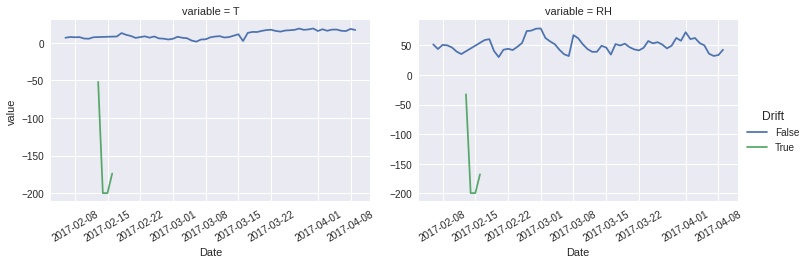

In [ ]:
df_test_raw['Drift'] = df_test_raw['T'] < 0 # Initialise a Drift Variable
g = sns.FacetGrid(
        pd.melt(df_test_raw, id_vars=['Date', 'Drift'], value_vars=['T','RH']).drop_duplicates(), 
        col="variable",
        hue='Drift',
        col_wrap= 2,
        sharey=False,
        height=3.5,
        aspect=1.5
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
g.add_legend()
plt.show()

In [ ]:
# Front Fill all values 
df_test_raw.loc[df_test_raw[df_test_raw['Drift']].index,['T','RH']] = np.nan 
df_test_raw_imp = df_test_raw.fillna(method='ffill')
df_test_raw_imp[df_test_raw_imp['Drift']]

,id,Date,T,RH,Gas,Unnamed: 5,Unnamed: 6,Drift
7,7,2017-02-13,7.307986,35.396875,CO,NaN,NaN,True
8,8,2017-02-14,7.307986,35.396875,CO,NaN,NaN,True
9,9,2017-02-15,7.307986,35.396875,CO,NaN,NaN,True
10,10,2017-02-16,7.307986,35.396875,CO,NaN,NaN,True
70,70,2017-02-13,7.307986,35.396875,HC,NaN,NaN,True
71,71,2017-02-14,7.307986,35.396875,HC,NaN,NaN,True
72,72,2017-02-15,7.307986,35.396875,HC,NaN,NaN,True
73,73,2017-02-16,7.307986,35.396875,HC,NaN,NaN,True
133,133,2017-02-13,7.307986,35.396875,NO2,NaN,NaN,True
134,134,2017-02-14,7.307986,35.396875,NO2,NaN,NaN,True


### Extract exogenous testing set

In [ ]:
X_test = df_test_raw_imp.set_index("Date")[['T', 'RH']].resample('d').mean()
X_test.head(10)

,T,RH
Date,,
2017-02-06,6.616667,51.734375
2017-02-07,7.613194,43.930903
2017-02-08,7.252083,50.966667
2017-02-09,7.473611,50.166319
2017-02-10,5.571875,46.604167
2017-02-11,5.310417,39.594792
2017-02-12,7.307986,35.396875
2017-02-13,7.307986,35.396875
2017-02-14,7.307986,35.396875


## VARMAX forecast on Kaggle test set

In [ ]:
final_train_endog = df_pivot_impute[target_feature]
final_train_exog = df_pivot_impute[['T','RH']]
Final_varmax = VARMAX(endog = final_train_endog,exog = final_train_exog, order=(1, 0)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


,variable,Value
id,,
0,CO,979.961194
1,CO,918.212614
2,CO,942.345544
3,CO,939.083319
4,CO,914.573859
...,...,...
247,O3,824.549796
248,O3,769.521579
249,O3,781.177006


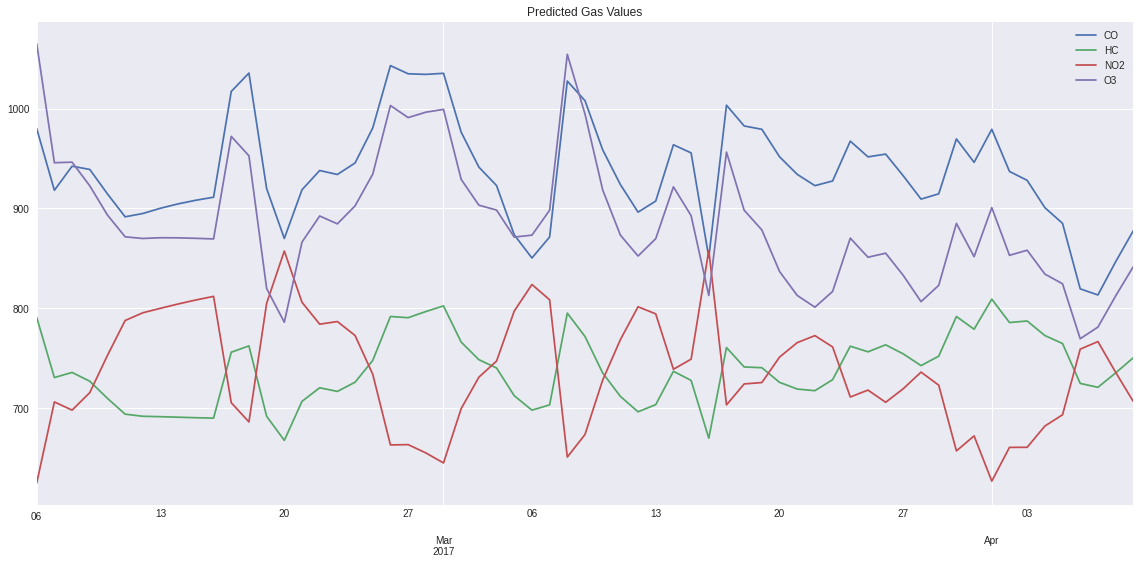

In [ ]:
predictions = model.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
predictions.plot()
plt.title('Predicted Gas Values')
predictions = pd.melt(predictions, value_vars=['CO', 'HC', 'NO2', 'O3'], value_name='Value')
predictions.index.rename('id', inplace=True)
predictions

## Padding -200 values

In [ ]:
predictions.Value[predictions.index.isin([8,9,71,72,134,135,197,198])] = -160
predictions[predictions.Value == -160]
predictions['id'] = range(0, len(predictions))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
predictions

,variable,Value,error,index
id,,,,
0,CO,979.961194,False,1
1,CO,918.212614,False,2
2,CO,942.345544,False,3
3,CO,939.083319,False,4
4,CO,914.573859,False,5
...,...,...,...,...
247,O3,824.549796,False,248
248,O3,769.521579,False,249
249,O3,781.177006,False,250


In [ ]:
predictions[['id','Value']].to_csv("/content/drive/MyDrive/Submissions/VARMAX1.csv",index=False)